# LSTM

Author: ZHANG Yu

The code is used to do calsssification of quickdraw dataset with 5 classes using LSTM. 




### The simplified process is:
1. Get data
2. Convert data to desired formation
3. Choose hyperparameters
4. Construct LSTM network
5. Train the network
6. Evaluate the network using test data

### To run the code:
1. Change path and parameters
2. Run the code

In [1]:
import sys
import os
os.environ["CUDA VISIBLE_DEVICES"]="0"
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv2D, Reshape
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from sklearn.metrics import confusion_matrix
import utils_
from utils_ import get_dataset, find_max_strok_point, convert_to_zeropad, label_onehot, plot_history


Using TensorFlow backend.


## Get data
test_r1=0.9 means stoke numbers in test_X1 is 90% of original data

In [2]:
data_path = '/raid5/liuchang/quick_draw_output' # change path here
data_name = '1102_05b633244'

train_X,train_Y,test_X,test_Y,test_X1,test_X2,test_X3=get_dataset(data_path,data_name,test_r1=0.9,test_r2=0.7,test_r3=0.5)




## Preprocess data
zero padding both train data and test data to same length

convert label to onehot form

In [3]:

max_stroke,max_point=find_max_strok_point(train_X,test_X)
train_data = convert_to_zeropad(train_X,max_stroke,max_point)
train_label = label_onehot(train_Y)
test_label = label_onehot(test_Y)
test_data = convert_to_zeropad(test_X,max_stroke,max_point)
test_data1 = convert_to_zeropad(test_X1,max_stroke,max_point)
test_data2 = convert_to_zeropad(test_X2,max_stroke,max_point)
test_data3 = convert_to_zeropad(test_X3,max_stroke,max_point)


max stroke number in train data = 30 
 max point number in train data = 200
training data number = 200000
max stroke number in test data = 30 
 max point number in test data = 200
test data number = 40000
done
done
done
done
done


## Setting parameters

In [5]:
bs = 128 # batch size, each batch has n images
seq_len = max_stroke 
input_size = 2*max_point 
hidden_size = 400
output_size = 5 # n calsses
EPOCH = 40 # train the training data n times


## Build lstm model

In [6]:
model = Sequential()
model.add(LSTM(hidden_size, activation='tanh', return_sequences=False, input_shape=(seq_len,input_size)))
model.add(Dense(output_size, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2005      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
Total params: 1,283,605
Trainable params: 1,283,605
Non-trainable params: 0
_________________________________________________________________


### Reducing learning rate by 0.9 every two epoch

In [7]:
def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)


## Compile model

In [10]:
adam = optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error',
          optimizer='adam',
          metrics=['accuracy'])

## Train and evaluate the model
plot loss and accuracy 

show test accuracy of complete and imcomplete images

Train on 160000 samples, validate on 40000 samples
Epoch 1/40
160000/160000 [==============================] - 638s 4ms/step - loss: 0.0746 - acc: 0.7219 - val_loss: 0.0432 - val_acc: 0.8731
Epoch 2/40
160000/160000 [==============================] - 663s 4ms/step - loss: 0.0666 - acc: 0.7469 - val_loss: 0.0345 - val_acc: 0.9058
Epoch 3/40
lr changed to 0.0009000000427477062
160000/160000 [==============================] - 660s 4ms/step - loss: 0.0619 - acc: 0.7617 - val_loss: 0.0325 - val_acc: 0.9142
Epoch 4/40
160000/160000 [==============================] - 648s 4ms/step - loss: 0.0591 - acc: 0.7712 - val_loss: 0.0323 - val_acc: 0.9173
Epoch 5/40
lr changed to 0.0008100000384729356
160000/160000 [==============================] - 633s 4ms/step - loss: 0.0577 - acc: 0.7768 - val_loss: 0.0296 - val_acc: 0.9230
Epoch 6/40
160000/160000 [==============================] - 650s 4ms/step - loss: 0.0562 - acc: 0.7812 - val_loss: 0.0288 - val_acc: 0.9256
Epoch 7/40
lr changed to 0.0007290000

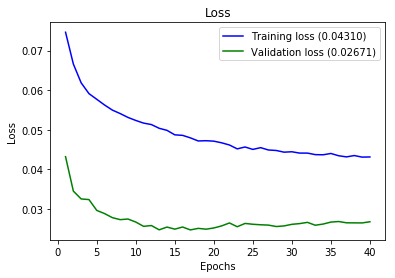

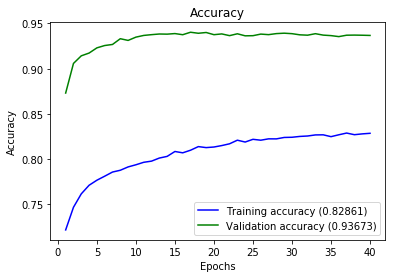

40000/40000 [==============================] - 54s 1ms/step
complete stroke test score: 0.02636064376682043
complete stroke test accuracy: 0.9378
40000/40000 [==============================] - 55s 1ms/step
90% stroke test score: 0.043125822818279265
90% stroke test accuracy: 0.865575
40000/40000 [==============================] - 53s 1ms/step
70% stroke test score: 0.05572024278640747
70% stroke test accuracy: 0.81975
40000/40000 [==============================] - 56s 1ms/step
50% stroke test score: 0.08793667861223221
50% stroke test accuracy: 0.6968


In [11]:
lr_decay = LearningRateScheduler(scheduler)
   

history = model.fit(train_data, train_label,
          batch_size = bs, epochs= EPOCH, 
          verbose=1,validation_split=0.2,callbacks=[lr_decay])

%matplotlib inline
plot_history(history)

test_loss, test_acc = model.evaluate(test_data, test_label,
                                         batch_size=bs)
print('complete stroke test score:', test_loss)
print('complete stroke test accuracy:', test_acc)

test_loss1, test_acc1 = model.evaluate(test_data1, test_label,
                                         batch_size=bs)
print('90% stroke test score:', test_loss1)
print('90% stroke test accuracy:', test_acc1)
test_loss2, test_acc2 = model.evaluate(test_data2, test_label,
                                         batch_size=bs)
print('70% stroke test score:', test_loss2)
print('70% stroke test accuracy:', test_acc2)
test_loss3, test_acc3 = model.evaluate(test_data3, test_label,
                                         batch_size=bs)
print('50% stroke test score:', test_loss3)
print('50% stroke test accuracy:', test_acc3)

## Plot confusion matrix of test data 

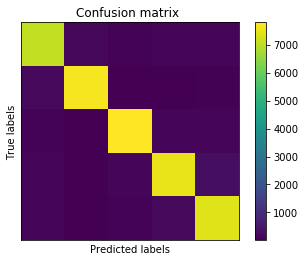

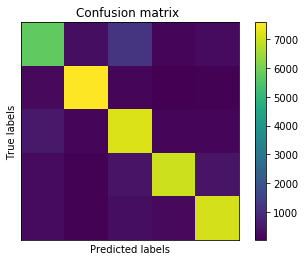

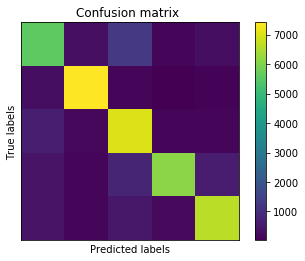

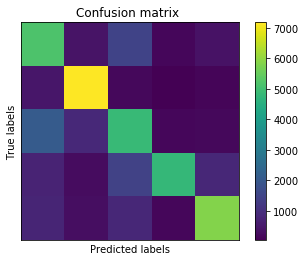

In [12]:
def test_confusion_matrix(test_data,test_Y):
    score_pred = model.predict(test_data)
    label_pred = np.argmax(score_pred,1)
    c_m = confusion_matrix(test_Y,label_pred)
    %matplotlib inline
    plt.imshow(c_m)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Confusion matrix ')
    plt.colorbar()
    plt.show()
    return 

test_confusion_matrix(test_data,test_Y)
test_confusion_matrix(test_data1,test_Y)
test_confusion_matrix(test_data2,test_Y)
test_confusion_matrix(test_data3,test_Y)


